In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline

sns.set(rc={'figure.figsize':(9, 3)})
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from data_loader import load_data, BenchmarkType, Benchmark, System

## Load NAS data

In [6]:
nas_container = load_data(BenchmarkType.BASELINE, System.DAINT_MC, Benchmark.NAS)

mean_nas = nas_container.groupby(['benchmark', 'size', 'ranks']).mean().reset_index()
dev_nas = nas_container.groupby(['benchmark', 'size', 'ranks']).std().reset_index()
median_nas = nas_container.groupby(['benchmark', 'size', 'ranks']).median().reset_index()


# Load MILC data

In [7]:
normal_milc_mc = load_data(BenchmarkType.BASELINE, System.DAINT_MC, Benchmark.MILC, ranks = 64, spread = 32)
normal_milc_mc['nodes'] = 2

avg_milc = normal_milc_mc.groupby(['size']).mean().reset_index()
median_milc = normal_milc_mc.groupby(['size']).median().reset_index()
dev_milc = normal_milc_mc.groupby(['size']).std().reset_index()

print(normal_milc_mc.groupby(['size']).count())

      repetition  time  ranks  ranks_per_node  system  type  application  \
size                                                                       
32            20    20     20              20      20    20           20   
64            20    20     20              20      20    20           20   
96            20    20     20              20      20    20           20   
128           20    20     20              20      20    20           20   

      nodes  
size         
32       20  
64       20  
96       20  
128      20  


# Load MILC co-location data

In [8]:
path, colocated_milc, colocated_nas_milc = load_data(BenchmarkType.COLOCATION_CPU, System.DAINT_MC,
                          Benchmark.MILC, colocated_benchmark = Benchmark.NAS, ranks = 64)

avg_colocated_milc = colocated_milc.groupby(['size', 'colocated_benchmark', 'colocated_benchmark_size']).mean().reset_index()
median_colocated_milc = colocated_milc.groupby(['size', 'colocated_benchmark', 'colocated_benchmark_size']).median().reset_index()
dev_colocated_milc = colocated_milc.groupby(['size', 'colocated_benchmark', 'colocated_benchmark_size']).std().reset_index()

mean_colocated_nas_milc = colocated_nas_milc.groupby(['benchmark', 'size', 'ranks', 'batch_benchmark_size']).mean().reset_index()
dev_colocated_nas_milc = colocated_nas_milc.groupby(['benchmark', 'size', 'ranks', 'batch_benchmark_size']).std().reset_index()
median_colocated_nas_milc = colocated_nas_milc.groupby(['benchmark', 'size', 'ranks', 'batch_benchmark_size']).median().reset_index()


In [9]:
print(avg_colocated_milc)

    size colocated_benchmark colocated_benchmark_size  repetition        time  \
0     32                  bt                        A   14.000000   86.003111   
1     32                  bt                        W   13.913043   86.898504   
2     32                  cg                        B   15.000000   87.449210   
3     32                  ep                        B   15.478261   87.261805   
4     32                  lu                        A   14.916667   86.052411   
5     32                  mg                        A   15.000000   86.693088   
6     32                  mg                        W   12.956522   87.129064   
7     64                  bt                        A   14.545455  161.775910   
8     64                  bt                        W   14.190476  163.487890   
9     64                  cg                        B   14.913043  167.488618   
10    64                  ep                        B   14.772727  162.850361   
11    64                  lu

# Compute slowdown data

In [41]:

df1 = avg_colocated_milc.set_index('size')
df2 = avg_milc.set_index('size')
df3 = dev_milc.set_index('size')
df4 = dev_colocated_milc.set_index('size')
df1['dev'] = df4['time'].reindex(df1.index)
df1['original_time'] = df2['time'].reindex(df1.index)
df1['original_dev'] = df3['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']

df1['slowdown_dev'] = df1['slowdown'] * np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

#print(df1)
#print(df2)

df3 = mean_colocated_nas_milc.set_index(['benchmark', 'size', 'ranks'])
#print(df3)
df4 = mean_nas.set_index(['benchmark', 'size', 'ranks'])
df10 = dev_nas.set_index(['benchmark', 'size', 'ranks'])
df11 = dev_colocated_nas_milc.set_index(['benchmark', 'size', 'ranks'])
#print(df4)
df3['original_dev'] = df10['time'].reindex(df3.index)
df3['original_time'] = df4['time'].reindex(df3.index)
df3['slowdown'] = df3['time'] / df3['original_time']
df3['dev'] = df11['time'].reindex(df3.index)
df3['slowdown_dev'] = df3['slowdown'] * np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)
#print(df3)

df5 = df1.reset_index().rename(columns={"size": "milc_size"})
df6 = df3.reset_index().rename(columns={"size": "benchmark_size"})
#print(df6)
print(df6)
df5 = df5.set_index(['colocated_benchmark', 'colocated_benchmark_size', 'milc_size'])
df6 = df6.set_index(['benchmark', 'benchmark_size', 'batch_benchmark_size'])
print(df5)
print('-')
print(df6)

df5['nas_slowdown'] = df6['slowdown'].reindex(df5.index)
df5['nas_slowdown_dev'] = df6['slowdown_dev'].reindex(df5.index)
print(df5)
df5.reset_index(inplace=True)

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}
print(df5)
df5['ranks'] = df5[['colocated_benchmark', 'colocated_benchmark_size']].apply(lambda x: p_map[x['colocated_benchmark']][x['colocated_benchmark_size']], axis=1)
#df5['p'] = p_map[df5['benchmark']][df5['bench_size']]
df5['type'] = df5.apply(lambda row: f"({row['colocated_benchmark'].upper()}, {row['colocated_benchmark_size']}, {row['ranks']})", axis=1)
df5.sort_values(by=['type'], inplace=True)
print(df5)

print(df5)
df5['rescaled_slowdown'] = (df5['slowdown']-1)*100
df5['rescaled_nas_slowdown'] = (df5['nas_slowdown']-1)*100
df5['rescaled_slowdown_dev'] = df5['slowdown_dev']*100
df5['rescaled_nas_slowdown_dev'] = df5['nas_slowdown_dev']*100
print(df5)

df5_modified = df5.drop(df5.loc[df5['type'] == '(MG, A, 1)'].index)



df5_modified.sort_values(by=['type', 'milc_size'], inplace=True)

   benchmark benchmark_size  ranks  batch_benchmark_size  \
0         bt              A      4                    32   
1         bt              A      4                    64   
2         bt              A      4                    96   
3         bt              A      4                   128   
4         bt              W      1                    32   
5         bt              W      1                    64   
6         bt              W      1                    96   
7         bt              W      1                   128   
8         cg              B      8                    32   
9         cg              B      8                    64   
10        cg              B      8                    96   
11        cg              B      8                   128   
12        ep              B      2                    32   
13        ep              B      2                    64   
14        ep              B      2                    96   
15        ep              B      2      

# Plot MILC

In [39]:
def barplot_err(x, y, xerr=None, yerr=None, data=None, hue=None, **kwargs):

    y_values = []
    yerr_values = []
    for hue_value in data[hue].unique():
        for x_value in data[x].unique():
            row = data.loc[(data[hue] == hue_value) & (data[x] == x_value)]
            y_values.append(row[y].values[0])
            yerr_values.append(row[yerr].values[0])
        
    _ax = sns.barplot(x=x,y=y,data=data, hue=hue, **kwargs)
    
    x_coords = [p.get_x() + 0.5*p.get_width() for p in _ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    
    print(x_coords)
    print(y_coords)
    print(y_values)
    print(yerr_values)

    _, caps,_ = _ax.errorbar(x=x_coords, y=y_coords, yerr=yerr_values, linewidth=2, 
                             solid_capstyle='round', solid_joinstyle='round', color='#464646', fmt="none", capsize=4.5)
    

    for cap in caps:
        cap.set_markeredgewidth(2)
        cap._marker._capstyle = matplotlib._enums.CapStyle.round

    return _ax


In [42]:
df5_modified[df5_modified['milc_size'] >= 96]

,colocated_benchmark,colocated_benchmark_size,milc_size,repetition,time,ranks,dev,original_time,original_dev,slowdown,slowdown_dev,nas_slowdown,nas_slowdown_dev,type,rescaled_slowdown,rescaled_nas_slowdown,rescaled_slowdown_dev,rescaled_nas_slowdown_dev
14,bt,A,96,14.750000,252.590363,4,0.929109,245.268432,20.644958,1.029853,0.086768,1.689133,0.188075,"(BT, A, 4)",2.985272,68.913311,8.676843,18.807519
21,bt,A,128,14.086957,357.331626,4,1.369557,334.452033,13.105233,1.068409,0.042065,1.813314,0.222505,"(BT, A, 4)",6.840919,81.331438,4.206455,22.250519
15,bt,W,96,13.954545,254.360901,1,3.494936,245.268432,20.644958,1.037072,0.088449,1.690806,0.134637,"(BT, W, 1)",3.707150,69.080560,8.844870,13.463672
22,bt,W,128,14.478261,359.115519,1,3.957011,334.452033,13.105233,1.073743,0.043706,1.800169,0.139246,"(BT, W, 1)",7.374297,80.016867,4.370562,13.924641
16,cg,B,96,14.500000,266.580340,8,3.838133,245.268432,20.644958,1.086892,0.092816,1.292387,0.178234,"(CG, B, 8)",8.689218,29.238732,9.281558,17.823374
23,cg,B,128,14.400000,375.976072,8,7.098525,334.452033,13.105233,1.124155,0.048896,1.432530,0.182159,"(CG, B, 8)",12.415544,43.253035,4.889579,18.215908
17,ep,B,96,15.208333,253.074204,2,4.028215,245.268432,20.644958,1.031825,0.088391,1.277633,0.085337,"(EP, B, 2)",3.182543,27.763317,8.839098,8.533689
24,ep,B,128,15.227273,355.227194,2,2.512612,334.452033,13.105233,1.062117,0.042291,1.286956,0.077816,"(EP, B, 2)",6.211701,28.695571,4.229083,7.781613
18,lu,A,96,16.047619,255.063440,4,1.319525,245.268432,20.644958,1.039936,0.087700,1.512302,0.105163,"(LU, A, 4)",3.993587,51.230241,8.769960,10.516265
25,lu,A,128,14.000000,359.875995,4,1.927035,334.452033,13.105233,1.076017,0.042555,1.594913,0.116743,"(LU, A, 4)",7.601677,59.491262,4.255472,11.674348


[-0.2, 0.8, 1.8, 2.8, 3.8, 4.8, 0.2, 1.2, 2.2, 3.2, 4.2, 5.2]
[2.985272378218351, 3.70715011842353, 8.68921768632891, 3.182542676282618, 3.9935868574796363, 4.473019802664391, 6.840919180336158, 7.374296868292718, 12.41554385509649, 6.211701086581578, 7.601676505992505, 7.934903932820703]
[2.985272378218351, 3.70715011842353, 8.68921768632891, 3.182542676282618, 3.9935868574796363, 4.473019802664391, 6.840919180336158, 7.374296868292718, 12.41554385509649, 6.211701086581578, 7.601676505992505, 7.934903932820703]
[8.676843434210415, 8.844869558218143, 9.281557693057632, 8.839097664886468, 8.769960258583884, 8.929078610839563, 4.206454564940263, 4.370561744025456, 4.889578872621819, 4.229082672133089, 4.255471640060448, 4.738070244887829]


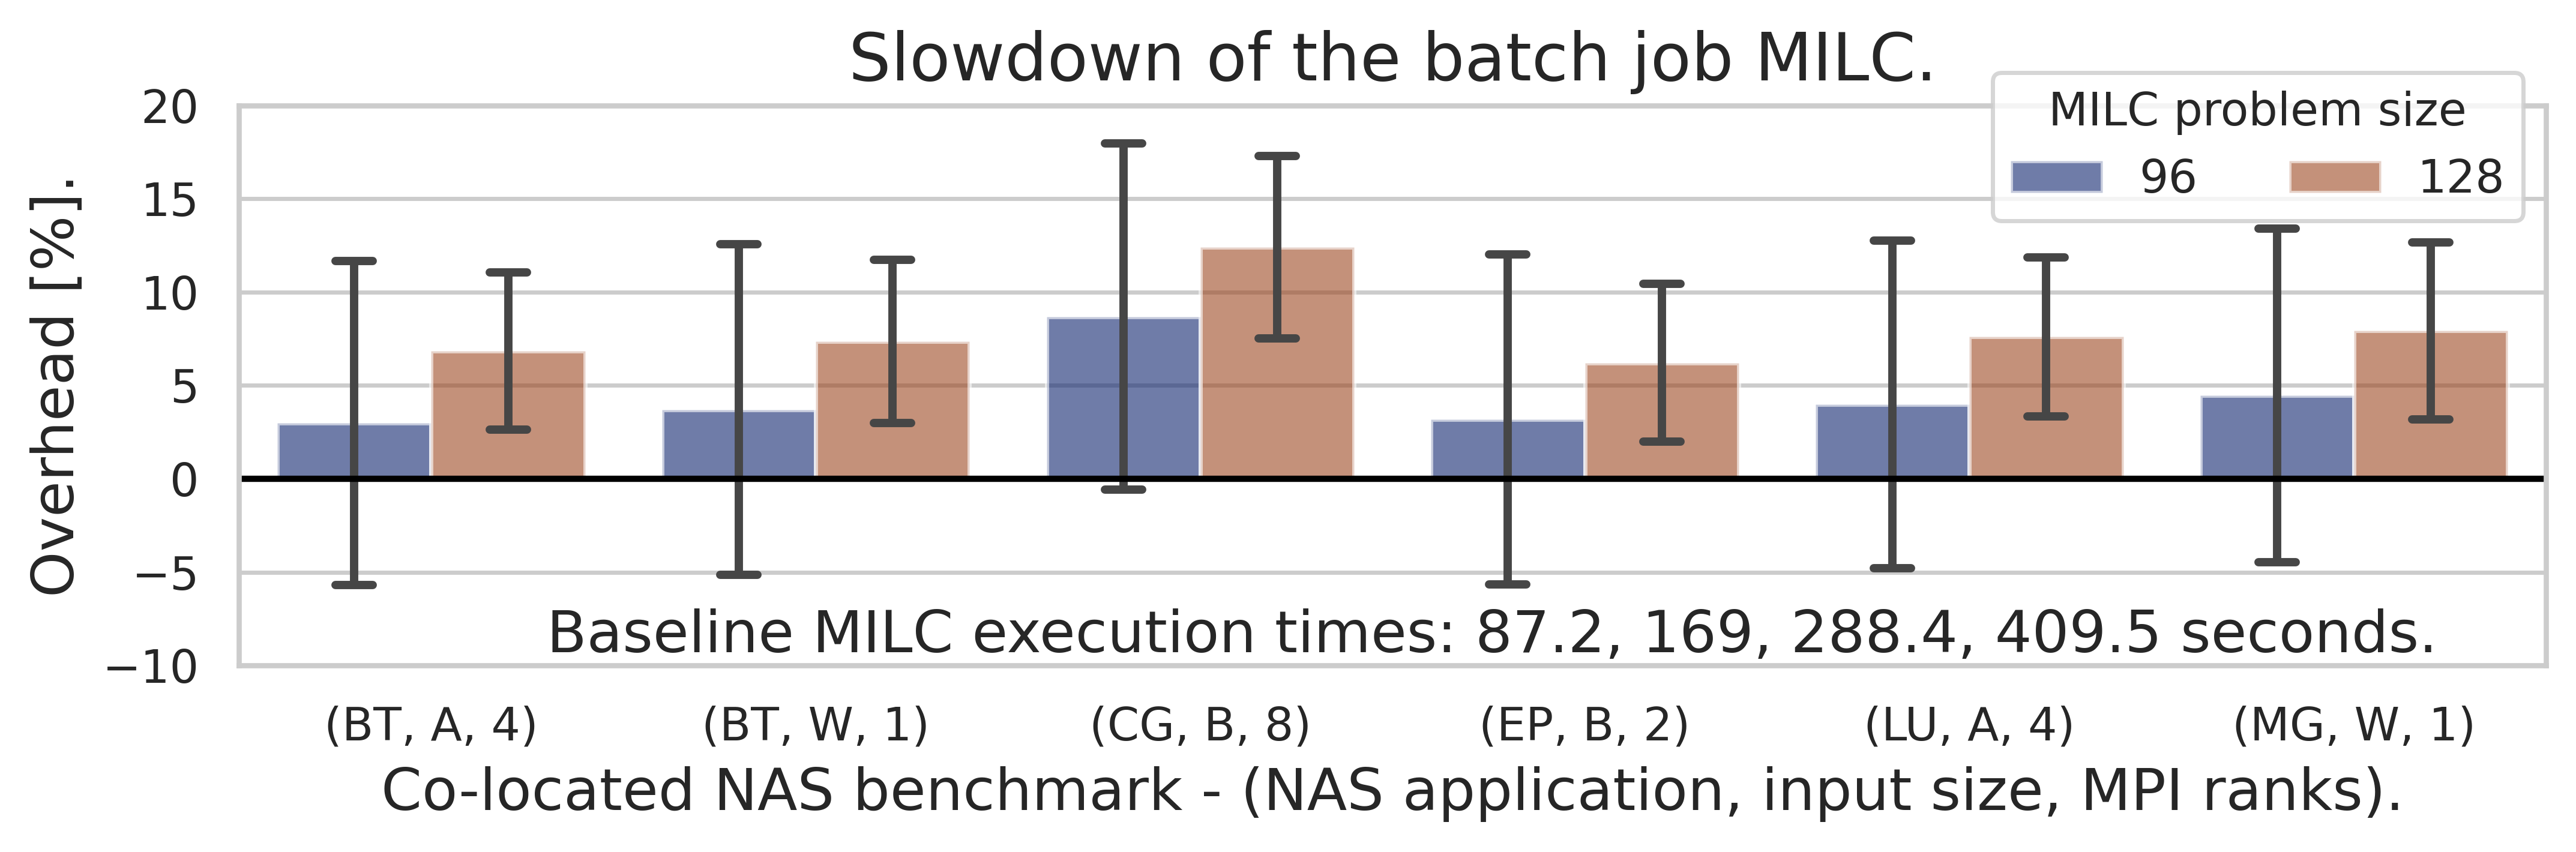

In [64]:
fig = plt.figure(figsize=(9,3))
ax = fig.gca()

g = barplot_err(y="rescaled_slowdown", x="type", yerr="rescaled_slowdown_dev", hue="milc_size",
                data=df5_modified[df5_modified['milc_size'] >= 96],palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located NAS benchmark - (NAS application, input size, MPI ranks).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
g.legend(title='MILC problem size', ncol=2, loc='upper right', fontsize=11,title_fontsize=11, bbox_to_anchor=(1.0,1.1))
#plt.legend.set_title('LULESH problem size',prop={'fontsize':14})
g.set_ylim([-10,20])
g.set_yticks([-10,-5,0,5,10,15,20])
g.axhline(y=0, color='black', linestyle='-')
g.set_xlim([-0.5,5.5])

plt.annotate("Baseline MILC execution times: 87.2, 169, 288.4, 409.5 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(0.3, -9.3), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots',  "cpu", "colocation_cpu_milc.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)